In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
n_hidden = 2000         # number of hidden units in hidden layer
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 1000          # number of epochs
batch_size = 1000        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates

# From the paper
# p ∈ {2, 3, 4, 5}
# k ∈ {2, 3}
# delta ∈ {0, 0.1, 0.2, 0.3}
lebesgue_norm = 2.0                     # Lebesgue norm of the weights. p
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2. k
anti_hebbian_learning_strength = 0.0    # Strength of the anti-hebbian learning. delta


In [4]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights
    #return weights.cpu().numpy()


In [6]:
# 1) LOAD CIFAR-10 DATA

transform = transforms.Compose([transforms.ToTensor()])
transform_grayscale = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# CIFAR-10 dataset 
# train_dataset = torchvision.datasets.CIFAR10(root='./gray_data', 
#                                             train=True, 
#                                             transform=transform,  
#                                             download=True)

# test_dataset = torchvision.datasets.CIFAR10(root='./gray_data', 
#                                           train=False, 
#                                           transform=transform)

train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=True, 
                                            transform=transform,  
                                            download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                          train=False, 
                                          transform=transform)

cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


(3, 32, 32)
(32, 32, 3)


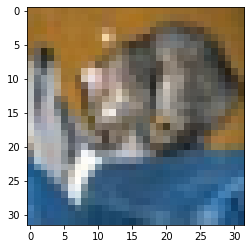

In [14]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

def imshow(img):
    # Unnormalize before plotting is not needed because there is no normalization applied yet at this point
    npimg = img.numpy()
    print(npimg.shape)
    npimg_transpose = np.transpose(npimg, (1, 2, 0))
    print(npimg_transpose.shape)
    plt.imshow(npimg_transpose)
    plt.show()
    
examples = iter(test_loader)
example_data, example_targets = examples.next()
image = example_data[0]
imshow(image)

#npimg = image.numpy()
#npimg = npimg.reshape(32, 32, 3) # DOES NOT WORK!
#npimg = np.transpose(npimg, (1, 2, 0)) # WORKS
# Using transpose instead of reshape actually help to display the image correctly
#print(npimg.shape)
#plt.imshow(npimg)



(3, 32, 32)
(32, 32, 3)
(3072, 1)
(32, 32, 3)


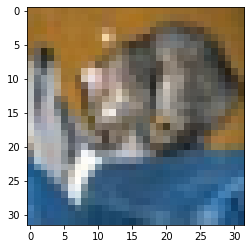

In [18]:
# Data loader and try something
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

def imshow_try(img):
    # Unnormalize before plotting is not needed because there is no normalization applied yet at this point
    npimg = img.numpy()
    print(npimg.shape)
    npimg_transpose = np.transpose(npimg, (1, 2, 0))
    print(npimg_transpose.shape)
    
    npimg_transpose_reshape = npimg_transpose.reshape(32*32*3, -1)
    print(npimg_transpose_reshape.shape)
    
    npimg_transpose_back = npimg_transpose_reshape.reshape(32, 32, 3)
    print(npimg_transpose_back.shape)
    
    #plt.imshow(npimg_transpose)
    plt.imshow(npimg_transpose_back)
    plt.show()
    
examples = iter(test_loader)
example_data, example_targets = examples.next()
image = example_data[0]
imshow_try(image)

#npimg = image.numpy()
#npimg = npimg.reshape(32, 32, 3) # DOES NOT WORK!
#npimg = np.transpose(npimg, (1, 2, 0)) # WORKS
# Using transpose instead of reshape actually help to display the image correctly
#print(npimg.shape)
#plt.imshow(npimg)



In [ ]:
# CONSTRUCT OBJECT REQUIRED FOR UNSUPERVISED LEARNING 
# Use temporary loaders to construct the required object

num_classes=10 # number of classes
num_pixels=32*32 # number of pixels for each image. 32x32
num_channels = 3 # RGB

#M = np.zeros((0, num_pixels*num_channels)) # Want 3072-dimensional space
M = np.zeros((num_pixels*num_channels, 0)) # Want 3072-dimensional space
# TODO Take transpose of M later
print(f'M.shape: {M.shape}')

train_loader_temp = torch.utils.data.DataLoader(train_dataset, batch_size=25000)

def img_print_try(img):
    npimg = img.numpy()
    #print(f'npimg.shape: {npimg.shape}')
    npimg_transpose = np.transpose(npimg, (1, 2, 0))
    #print(f'npimg_transpose.shape: {npimg_transpose.shape}')
    
    npimg_transpose_reshape = npimg_transpose.reshape(32*32*3, -1)
    #print(f'npimg_transpose_reshape.shape: {npimg_transpose_reshape.shape}')
    
    return npimg_transpose_reshape


# Ensure M has shape (num_samples, 3072)
# For MNIST, M had the following shape before applying unsupervised learning: (60000, 784)
# Do in a couple iterations, each handling half of the training data
x = 0
for i, (images, labels) in enumerate(train_loader_temp):
    print(f'i : {i}')
    print(f'images.shape: {images.shape}')
    
    for image in images:
        #print(f'image.shape: {image.shape}')
        image_transpose = img_print_try(image)
        #print(f'image_transpose.shape: {image_transpose.shape}')
        M=np.concatenate((M, image_transpose), axis=1)
        if (x+1) % 1000 == 0:
            print(f'x: {x+1}')
        x = x+1
    
    print(f'### M.shape: {M.shape}')
    
    # I think safe to delete stuff below
    #np_images = images.numpy()
    #print(np_images.shape)
    #np_images_transpose = np.transpose(np_images, (1, 2, 0))
    #print(np_images_transpose.shape)
    
    #images = torch.reshape(images, (25000,-1)).numpy()
    #M=np.concatenate((M, images), axis=0)

print(f'FINAL M.shape: {M.shape}')
print("Fin")

M.shape: (3072, 0)
i : 0
images.shape: torch.Size([25000, 3, 32, 32])
x: 1000
x: 2000
x: 3000
x: 4000
x: 5000
x: 6000
x: 7000
x: 8000
x: 9000
x: 10000
x: 11000
x: 12000
x: 13000
x: 14000
x: 15000
x: 16000
x: 17000
x: 18000
x: 19000
x: 20000
x: 21000
x: 22000


In [ ]:

for i, (images, labels) in enumerate(train_loader_grayscale):
    print(images.shape)
    images = torch.reshape(images, (25000,-1)).numpy()    
    M_grayscale=np.concatenate((M_grayscale, images), axis=0)
    
data = M
data_grayscale = M_grayscale


print(data.shape)
print(data_grayscale.shape)

data_cifar = data
data_cifar_grayscale = data_grayscale


# NORMALIZATION as per the "Hidden Competing Units" paper
# L2-normalize the training samples to unit vectors.
#data_cifar = preprocessing.normalize(data, norm='l2')
#print(f'CIFAR-10 training data shape: {data_cifar.shape}')
#print(f'Number of CIFAR-10 training samples: {data_cifar.shape[0]}')
#print(f'Number of CIFAR-10 features: {data_cifar.shape[1]}')


# Test print normalized data
#sample_data = data_cifar[0]
#print(sample_data.shape)
#print("Magnitude of the normalized vector:")
#print(np.linalg.norm(sample_data))
#print(sample_data)
#print(np.amax(data_cifar))
#print(np.amin(data_cifar))

In [ ]:
M_backup = M
M_frozen = M


In [ ]:
# TRY TO SEE IF M IS BEING CONSTRUCTED PROPERLY BY PLOTTING THE IMAGES AFTER M IS CONSTRUCTED

def imshow_try(img):
    # Unnormalize before plotting is not needed because there is no normalization applied yet at this point
    npimg = img.numpy()
    print(npimg.shape)
    npimg_transpose = np.transpose(npimg, (1, 2, 0))
    print(npimg_transpose.shape)
    
    npimg_transpose_reshape = npimg_transpose.reshape(32*32*3, -1)
    print(npimg_transpose_reshape.shape)
    
    npimg_transpose_back = npimg_transpose_reshape.reshape(32, 32, 3)
    print(npimg_transpose_back.shape)
    
    #plt.imshow(npimg_transpose)
    plt.imshow(npimg_transpose_back)
    plt.show()
    
examples = iter(test_loader)
example_data, example_targets = examples.next()
image = example_data[0]
imshow_try(image)